[ 사전학습을 통한 갱얼쥐 고얌미 모델 ]

In [162]:
# [1] 모듈 로딩
import torch
import torch.nn as nn                          # 인공신경망 관련
import torch.nn.functional as F                # 인공신경망 함수들 관련

from torchvision.models import alexnet, AlexNet_Weights
from torchinfo import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms    # 이미지 전처리 변형 관련
from torch.utils.data import DataLoader   
from torch.utils.data import Subset, random_split
from torchvision.datasets import ImageFolder     

import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

import os

from sklearn.model_selection import train_test_split 
import torch.optim as optim                                    # PyTorch: 최적화 알고리즘 관련 클래스
from torch.utils.data import Dataset, DataLoader 
import torchmetrics.functional as mt                           # PyTorch Metrics: 함수형 모듈 (정확도 등)
from torchmetrics.classification import *                      # PyTorch Metrics: 분류 관련 메트릭스 클래스 및 함수
from torch.optim.lr_scheduler import ReduceLROnPlateau         # PyTorch: 학습률 감소 스케줄링 클래스

In [163]:
# [2] 데이터 밑준비
DATA_DIR = '../data/image/animal/'

# 이미지 전처리 준비 
Preprocessing = AlexNet_Weights.DEFAULT.transforms()

# # 이미지 클래스 변환 (기존 알렉스넷 카테고리)
# idx_to_class = dict(zip(range(1000), AlexNet_Weights.DEFAULT.meta['categories']))

In [164]:
# 이미지 데이터 로딩 : 파일 명을 기준으로 분리
imgDS = ImageFolder(root=DATA_DIR,
                    transform=Preprocessing)

# 클래스 변환 데이터 (갱얼쥐 고얌미 전용 카테고리)
idx_to_class = {v:k for k,v in imgDS.class_to_idx.items()}
print(idx_to_class)

{0: 'cat', 1: 'dog'}


In [165]:
# 데이터 확인
print(f'imgDataset 개수 : {len(imgDS.targets)}개')
print(f'imgDataset 분류 : {imgDS.class_to_idx}')
print(f'- cat      개수 : {imgDS.targets.count(0)}개, {(imgDS.targets.count(0)/len(imgDS.targets))*100}')
print(f'- dog      개수 : {imgDS.targets.count(1)}개, {(imgDS.targets.count(1)/len(imgDS.targets))*100}')

imgDataset 개수 : 143개
imgDataset 분류 : {'cat': 0, 'dog': 1}
- cat      개수 : 62개, 43.35664335664335
- dog      개수 : 81개, 56.64335664335665


In [166]:
# 데이터 확인
# label : 타겟
img, label = imgDS[0] 
print(f'img => {img.shape}, label => {label}')

img => torch.Size([3, 224, 224]), label => 0


In [167]:
# 모델 클래스 정의 및 선언
# 모델 구성 : 사전 학습된 AlexNet의 특징 추출 부분 + 커스텀 분류기 부분 
#            - 특징 추출 부분 : 최적의 w, b로 설정되어 있음 => 학습 X => requires_grad False 설정
#            - 분류기    부분 : 커스터마이징 => 학습 필요 => requires_grad True 설정

In [168]:
# (1) 사전 학습된 모델 인스턴스 로딩
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# 원래 모델
summary(model, input_size = (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [169]:
# (2) 모델 층별 특성 확인
# features 부분 (requires_grad = False)
# classifier 부분 (requires_grad = True)
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

features.0.weight torch.Size([64, 3, 11, 11]) True
features.0.bias torch.Size([64]) True
features.3.weight torch.Size([192, 64, 5, 5]) True
features.3.bias torch.Size([192]) True
features.6.weight torch.Size([384, 192, 3, 3]) True
features.6.bias torch.Size([384]) True
features.8.weight torch.Size([256, 384, 3, 3]) True
features.8.bias torch.Size([256]) True
features.10.weight torch.Size([256, 256, 3, 3]) True
features.10.bias torch.Size([256]) True
classifier.1.weight torch.Size([4096, 9216]) True
classifier.1.bias torch.Size([4096]) True
classifier.4.weight torch.Size([4096, 4096]) True
classifier.4.bias torch.Size([4096]) True
classifier.6.weight torch.Size([1000, 4096]) True
classifier.6.bias torch.Size([1000]) True


In [170]:
FeatureLayers = model.features                # 이미지 특징 추출 부분 (Feature Map 추출)
ClassifierLayers = model.classifier           # 분류기 부분 (Full-Connected)

In [171]:
FeatureLayers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [172]:
ClassifierLayers

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [173]:
# (3) 분류기 부분 변경 => 6번 분류기를 4096,2로 설정함 
model.classifier[6] = nn.Linear(4096, 2)

In [174]:
# 변경된 모델
summary(model, input_size = (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [175]:
# (2) 모델 층별 W,b 파라미터 업데이트 설정 
# features 부분 (requires_grad = False)
# classifier 부분 (requires_grad = True)
for name, param in model.named_parameters():
    
    if name.startswith('features'):
        param.requires_grad=False
    print(name, param.shape, param.requires_grad)

features.0.weight torch.Size([64, 3, 11, 11]) False
features.0.bias torch.Size([64]) False
features.3.weight torch.Size([192, 64, 5, 5]) False
features.3.bias torch.Size([192]) False
features.6.weight torch.Size([384, 192, 3, 3]) False
features.6.bias torch.Size([384]) False
features.8.weight torch.Size([256, 384, 3, 3]) False
features.8.bias torch.Size([256]) False
features.10.weight torch.Size([256, 256, 3, 3]) False
features.10.bias torch.Size([256]) False
classifier.1.weight torch.Size([4096, 9216]) True
classifier.1.bias torch.Size([4096]) True
classifier.4.weight torch.Size([4096, 4096]) True
classifier.4.bias torch.Size([4096]) True
classifier.6.weight torch.Size([2, 4096]) True
classifier.6.bias torch.Size([2]) True


In [176]:
## 전체 데이터 수 체크
print('[전체 데이터 수 체크 ]', len(imgDS.imgs), len(imgDS.targets))

## 비율 기준 설정
targets = imgDS.targets

## -------(2) 훈련용:검증용:테스트용 데이터 인덱스 추출
## 1단계: 학습용과 검증용 데이터셋 분리
train_indices, valid_indices = train_test_split(range(len(imgDS.targets)),
                                                test_size=0.2, random_state=42, 
                                                stratify=targets)

## 2단계: 검증용 데이터셋을 테스트용 데이터셋 분리
targets = [ targets[index] for index in valid_indices ]
valid_indices, test_indices= train_test_split( valid_indices,
                                               test_size=0.5, random_state=42, 
                                               stratify=targets)

## -------(3) 훈련용:검증용:테스트용 데이터셋 생성
trainDS = Subset(imgDS, train_indices)
validDS = Subset(imgDS, valid_indices)
testDS = Subset(imgDS, test_indices)

## -------(4) 분리 데이터셋의 클래스 비율 체크
for kind, indices in zip(['Train','Valid','Test'], [trainDS.indices, validDS.indices, testDS.indices]):
    targets = [ imgDS.targets[ idx ] for idx in indices ]
    print(f'\n[{kind} 전체 데이터셋 개수 : {len(targets)}개')
    print(f'        - cat      개수 : {targets.count(0):02}개 {(targets.count(0)/len(targets))*100:.2f}')
    print(f'        - dog      개수 : {targets.count(1):02}개 {(targets.count(1)/len(targets))*100:.2f}')

[전체 데이터 수 체크 ] 143 143

[Train 전체 데이터셋 개수 : 114개
        - cat      개수 : 49개 42.98
        - dog      개수 : 65개 57.02

[Valid 전체 데이터셋 개수 : 14개
        - cat      개수 : 06개 42.86
        - dog      개수 : 08개 57.14

[Test 전체 데이터셋 개수 : 15개
        - cat      개수 : 07개 46.67
        - dog      개수 : 08개 53.33


In [177]:
## - 훈련용/검증용/테스트용 데이터 로더 생성
trainDL = DataLoader(trainDS, 
                     shuffle=True, 
                     generator=torch.Generator().manual_seed(42))
validDL = DataLoader(validDS, shuffle=False)
testDL  = DataLoader(testDS,  shuffle=False)

In [178]:
# 학습 관련 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)    # to(device) : 모델과 데이터를 지정한 장치로 옮기는 작업 수행 
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
epoch = 5
BATCH_SIZE = 4

In [179]:
# 학습 
for epoch in range(epoch):
    cost = 0.0
    
    for images,classes in trainDL:
        images = images.to(device)
        classes = classes.to(device)
        
        output = model(images)
        loss = criterion(output,classes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost += loss
        
    cost = cost / len(trainDL)
    print(f'Epoch : {epoch+1:4d}, Cost : {cost:.3f}')

Epoch :    1, Cost : 0.124
Epoch :    2, Cost : 0.005
Epoch :    3, Cost : 0.003
Epoch :    4, Cost : 0.003
Epoch :    5, Cost : 0.003


In [180]:
# 검증 
with torch.no_grad():
    model.eval()
    
    accuracy = 0.0
    for images, classes in validDL:
        images = images.to(device)
        classes = classes.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)
        
        accuracy += int(torch.eq(classes, outputs_classes).sum())
        print(f'acc@1 : {accuracy / (len(validDL)*BATCH_SIZE)*100:.2f}%')
        
torch.save(model.state_dict(), './models/alexnet.pt')
print( "Saved the model weights" )


acc@1 : 0.00%
acc@1 : 1.79%
acc@1 : 3.57%
acc@1 : 5.36%
acc@1 : 7.14%
acc@1 : 8.93%
acc@1 : 10.71%
acc@1 : 12.50%
acc@1 : 14.29%
acc@1 : 16.07%
acc@1 : 17.86%
acc@1 : 19.64%
acc@1 : 21.43%
acc@1 : 23.21%
Saved the model weights


In [181]:
# 이미지 예측 테스트

# 이미지 경로 가져오기
IMG_DIR = '../data/image/hello/'

IMG_LIST = os.listdir(IMG_DIR)
print(f'IMG_LIST => {IMG_LIST}')

IMG_LIST = [IMG_DIR + filename for filename in IMG_LIST if filename.endswith('.jfif')]
print(f'IMG_LIST => {IMG_LIST}')

IMG_LIST => ['goyang.jfif', 'pome.jfif']
IMG_LIST => ['../data/image/hello/goyang.jfif', '../data/image/hello/pome.jfif']


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=340x279 at 0x2D8BC1F2970>
전처리 이후 shape : torch.Size([3, 224, 224])
shape 일치 이후 shape : torch.Size([1, 3, 224, 224])
torch.Size([1, 2]) 0 cat


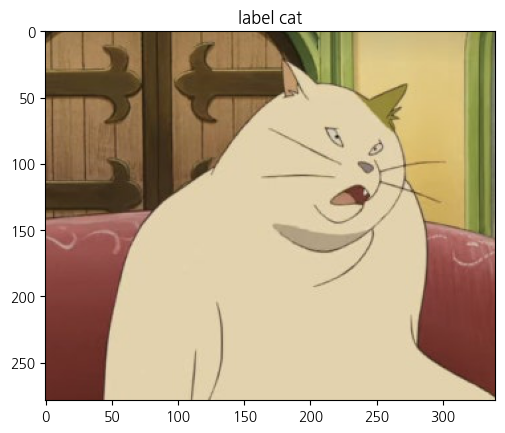

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=340x437 at 0x2D8BE479580>
전처리 이후 shape : torch.Size([3, 224, 224])
shape 일치 이후 shape : torch.Size([1, 3, 224, 224])
torch.Size([1, 2]) 1 dog


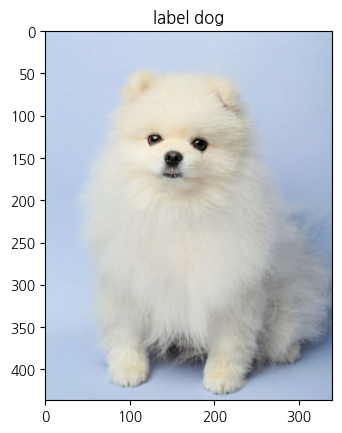

In [190]:
# 이미지 로딩 후 전처리
from PIL import Image
from torchvision import transforms

preprocessing = AlexNet_Weights.DEFAULT.transforms()

for imgfile in IMG_LIST:
    
    # 흑백 여부와 사이즈 확인
    img = Image.open(imgfile)
    print(img)
    
    # 동일 전처리
    trans_img = preprocessing(img)
    print(f'전처리 이후 shape : {trans_img.shape}') 
    
    # shape 일치
    trans_img.unsqueeze_(0)
    print(f'shape 일치 이후 shape : {trans_img.shape}')  
    
    # 예측
    # pre 값들 중 가장 큰 값 
    pre = model(trans_img)
    pre_target = pre.max(dim=1)[1].item()
    print(f'{pre.shape} {pre_target} {idx_to_class.get(pre_target,"NONE")}')
    
    plt.imshow(img)
    plt.title(f'label {idx_to_class.get(pre_target,"NONE")}')
    plt.show()